In [1]:
import os
import pandas as pd
import numpy as np
import torch

import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
# check if CUDA is available
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


In [3]:
# The MNIST datasets are hosted on yann.lecun.com that has moved under CloudFlare protection
# Run this script to enable the datasets download
# Reference: https://github.com/pytorch/vision/issues/1938

from six.moves import urllib
opener = urllib.request.build_opener()
opener.addheaders = [('User-agent', 'Mozilla/5.0')]
urllib.request.install_opener(opener)

In [4]:
from torchvision import datasets
import torchvision.transforms as transforms

# número de subprocessos a serem usados ​​para carregamento de dados
num_workers = 0
# quantas amostras por lote carregar
batch_size = 20

# converter dados para torch.FloatTensor
#transform = transforms.ToTensor()

transform = transforms.Compose([
    transforms.Resize(224),
    transforms.ToTensor()
])

# escolher os datasets de treino e teste
train_data = datasets.FashionMNIST(root='data', train=True, download=True, transform=transform)
test_data = datasets.FashionMNIST(root='data', train=False, download=True, transform=transform)

# peparar os dataloaders
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=num_workers)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, num_workers=num_workers)

# specify the image classes
classes = ["T-shirt/Top", "Trouser", "Pullover", "Dress", "Coat",
           "Sandal", "Shirt", "Sneaker", "Bag", "Ankle Boot"]

C:\Users\arthu\AppData\Local\Temp/ipykernel_6528/1110137839.py:12: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])


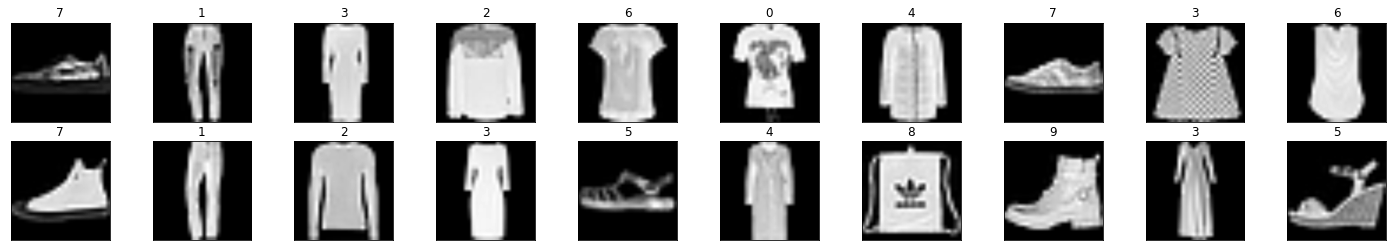

In [5]:
import matplotlib.pyplot as plt
%matplotlib inline
    
# obter um lote de imagens de treinamento
dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.numpy()

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(images[idx]), cmap='gray')
    # print out the correct label for each image
    # .item() gets the value contained in a Tensor
    ax.set_title(str(labels[idx].item()))

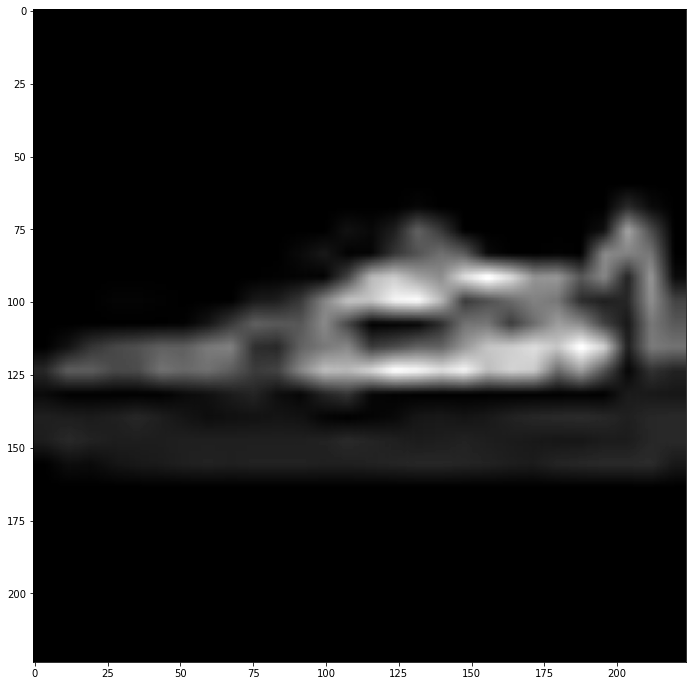

In [6]:
#observar uma imagem mais detalhadamente

img = np.squeeze(images[0])

fig = plt.figure(figsize = (12,12)) 
ax = fig.add_subplot(111)
ax.imshow(img, cmap='gray')
width, height = img.shape
thresh = img.max()/2.5
for x in range(width):
    for y in range(height):
        val = round(img[x][y],2) if img[x][y] !=0 else 0
        #ax.annotate(str(val), xy=(y,x),
                    #horizontalalignment='center',
                    #verticalalignment='center',
                    #color='white' if img[x][y]<thresh else 'black')

In [7]:
import torch.nn as nn

# Load the pretrained model from pytorch
model = models.vgg16(pretrained=True)
model.features[0] = nn.Conv2d(1, 64, 3, 1, 1)

# print out the model structure
print(model)

VGG(
  (features): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [8]:
print(model.classifier[6].in_features) 
print(model.classifier[6].out_features) 

4096
1000


In [9]:
# Freeze training for all "features" layers
for param in model.features.parameters():
    param.requires_grad = False
    
model.features[0].weight.requires_grad = True

In [10]:
import torch.nn as nn## TODO: add a last linear layer  that maps n_inputs -> 5 flower classes
## new layers automatically have requires_grad = True

n_inputs = model.classifier[6].in_features

last_layer = nn.Linear(n_inputs,len(classes))
model.classifier[6] = last_layer
# after completing your model, if GPU is available, move the model to GPU
if train_on_gpu:
    model.cuda()
model.classifier[6]

Linear(in_features=4096, out_features=10, bias=True)

In [11]:
#x = model.features[0](torch.tensor(images).cuda())
#x = model.features[30](x)
#images.shape
#model.features[0](images)

In [12]:
import torch.optim as optim

# specify loss function (categorical cross-entropy)
criterion = nn.CrossEntropyLoss()

# specify optimizer (stochastic gradient descent) and learning rate = 0.001
optimizer = optim.SGD(model.classifier.parameters(), lr=0.001)

In [13]:
# number of epochs to train the model
n_epochs = 3

for epoch in range(1, n_epochs+1):

    # keep track of training and validation loss
    train_loss = 0.0
    
    # model by default is set to train
    for batch_i, (images, labels) in enumerate(train_loader):
        # move tensors to GPU if CUDA is available
        if train_on_gpu:
            images, labels = images.cuda(), labels.cuda()
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(images)
        # calculate the batch loss
        loss = criterion(output, labels)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update training loss 
        train_loss += loss.item()
        
        if batch_i % 20 == 19:    # print training loss every specified number of mini-batches
            print('Epoch %d, Batch %d loss: %.16f' %
                  (epoch, batch_i + 1, train_loss / 20))
            train_loss = 0.0

Epoch 1, Batch 20 loss: 2.3124856352806091
Epoch 1, Batch 40 loss: 2.3235434651374818
Epoch 1, Batch 60 loss: 2.3144055843353271
Epoch 1, Batch 80 loss: 2.3086599826812746
Epoch 1, Batch 100 loss: 2.3063153386116029
Epoch 1, Batch 120 loss: 2.3149220705032350
Epoch 1, Batch 140 loss: 2.2912709832191469
Epoch 1, Batch 160 loss: 2.2900982260704041
Epoch 1, Batch 180 loss: 2.2961824417114256
Epoch 1, Batch 200 loss: 2.2828127861022951
Epoch 1, Batch 220 loss: 2.2875819921493532
Epoch 1, Batch 240 loss: 2.2772638201713562
Epoch 1, Batch 260 loss: 2.2751809477806093
Epoch 1, Batch 280 loss: 2.2915348768234254
Epoch 1, Batch 300 loss: 2.2941442370414733
Epoch 1, Batch 320 loss: 2.2822129726409912
Epoch 1, Batch 340 loss: 2.2655527591705322
Epoch 1, Batch 360 loss: 2.2937326550483705
Epoch 1, Batch 380 loss: 2.2641337990760801
Epoch 1, Batch 400 loss: 2.2660718917846681
Epoch 1, Batch 420 loss: 2.2679157376289369
Epoch 1, Batch 440 loss: 2.2618052005767821
Epoch 1, Batch 460 loss: 2.265892267

Epoch 2, Batch 720 loss: 1.5088229715824126
Epoch 2, Batch 740 loss: 1.4928692996501922
Epoch 2, Batch 760 loss: 1.4275982558727265
Epoch 2, Batch 780 loss: 1.4511883854866028
Epoch 2, Batch 800 loss: 1.4593545019626617
Epoch 2, Batch 820 loss: 1.4618818879127502
Epoch 2, Batch 840 loss: 1.4953644931316377
Epoch 2, Batch 860 loss: 1.4764355003833771
Epoch 2, Batch 880 loss: 1.4351010024547577
Epoch 2, Batch 900 loss: 1.4357136726379394
Epoch 2, Batch 920 loss: 1.4345527172088623
Epoch 2, Batch 940 loss: 1.4244764387607574
Epoch 2, Batch 960 loss: 1.4036117374897004
Epoch 2, Batch 980 loss: 1.4580058515071870
Epoch 2, Batch 1000 loss: 1.4707594096660614
Epoch 2, Batch 1020 loss: 1.4133254468441010
Epoch 2, Batch 1040 loss: 1.4771387338638307
Epoch 2, Batch 1060 loss: 1.4160172998905183
Epoch 2, Batch 1080 loss: 1.4098800539970398
Epoch 2, Batch 1100 loss: 1.3700725078582763
Epoch 2, Batch 1120 loss: 1.4384290695190429
Epoch 2, Batch 1140 loss: 1.4469040632247925
Epoch 2, Batch 1160 loss

Epoch 3, Batch 1400 loss: 1.0379294067621232
Epoch 3, Batch 1420 loss: 1.0045886188745499
Epoch 3, Batch 1440 loss: 1.0819804400205613
Epoch 3, Batch 1460 loss: 1.0584023892879486
Epoch 3, Batch 1480 loss: 1.1061050593852997
Epoch 3, Batch 1500 loss: 1.0702243685722350
Epoch 3, Batch 1520 loss: 1.0945496320724488
Epoch 3, Batch 1540 loss: 1.0540089875459671
Epoch 3, Batch 1560 loss: 1.0624150574207305
Epoch 3, Batch 1580 loss: 1.0759067863225937
Epoch 3, Batch 1600 loss: 1.0646149039268493
Epoch 3, Batch 1620 loss: 1.0333854228258132
Epoch 3, Batch 1640 loss: 1.0247542858123779
Epoch 3, Batch 1660 loss: 1.0827196717262269
Epoch 3, Batch 1680 loss: 1.0257629901170731
Epoch 3, Batch 1700 loss: 1.0454956829547881
Epoch 3, Batch 1720 loss: 1.0295559674501420
Epoch 3, Batch 1740 loss: 1.0016626268625259
Epoch 3, Batch 1760 loss: 0.9562005132436753
Epoch 3, Batch 1780 loss: 1.0018127590417862
Epoch 3, Batch 1800 loss: 1.0379975378513335
Epoch 3, Batch 1820 loss: 1.0475783258676530
Epoch 3, B

In [14]:
# track test loss 
# over 5 flower classes
test_loss = 0.0
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

model.eval() # eval mode

# iterate over test data
for images, labels in test_loader:
    # move tensors to GPU if CUDA is available
    if train_on_gpu:
        images, labels = images.cuda(), labels.cuda()
    # forward pass: compute predicted outputs by passing inputs to the model
    output = model(images)
    # calculate the batch loss
    loss = criterion(output, labels)
    # update  test loss 
    test_loss += loss.item()*images.size(0)
    # convert output probabilities to predicted class
    _, pred = torch.max(output, 1)    
    # compare predictions to true label
    correct_tensor = pred.eq(labels.data.view_as(pred))
    correct = np.squeeze(correct_tensor.numpy()) if not train_on_gpu else np.squeeze(correct_tensor.cpu().numpy())
    # calculate test accuracy for each object class
    for i in range(batch_size):
        label = labels.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1

# calculate avg test loss
test_loss = test_loss/len(test_loader.dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))

for i in range(5):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            classes[i], 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

Test Loss: 0.910395

Test Accuracy of T-shirt/Top: 80% (801/1000)
Test Accuracy of Trouser: 92% (924/1000)
Test Accuracy of Pullover: 47% (473/1000)
Test Accuracy of Dress: 69% (691/1000)
Test Accuracy of  Coat: 50% (506/1000)

Test Accuracy (Overall): 68% (6857/10000)
